In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from imgaug import augmenters as iaa



In [2]:
data_dir = r'PTSRD\Real Data'

label_mapping = {
    'airport': 0,
    'Animal_Crossing_Sign': 1,
    'Bridge Ahead': 2,
    'Bus_Stop': 3,
    'Cross Roads': 4,
    'Danger_Ahead': 5,
    'Dense_Ahead': 6,
    'Dinning_Place': 7,
    'DownHeal_Step': 8,
    'Give Way': 9,
    'Go_Straight_ahead': 10,
    'Hospital': 11,
    'Land_Sliding': 12,
    'Left bend': 13,
    'MotorWay_Start': 14,
    'No entry for Bikes': 15,
    'No entry for car': 16,
    'No entry for Cycles': 17,
    'No entry for Goods vehicle': 18,
    'No entry for hand crafts': 19,
    'no entry for vehical more than 16.6 feet': 20,
    'No Entry Vehicle weight 70 ton': 21,
    'No Horns': 22,
    'No left turn': 23,
    'No Mobile Allowed': 24,
    'No Overtaking': 25,
    'No Parking': 26,
    'No right turn': 27,
    'No U-Turn': 28,
    'no walking for pedistrians': 29,
    'No_Entry for aniamal vehicle': 30,
    'One Way ROad': 31,
    'parking on left': 32,
    'Pedestrians': 33,
    'petrol pump 3': 34,
    'Railway Crossing': 35,
    'Right bend': 36,
    'right turn': 37,
    'road crossing': 38,
    'Road Divides': 39,
    'Roundabout Ahead': 40,
    'Sharp Right Turn': 41,
    'Slow': 42,
    'Speed Breaker Ahead': 43,
    'Speed Limit (20 kmph)': 44,
    'Speed Limit (25 kmph)': 45,
    'Speed Limit (30 kmph)': 46,
    'Speed Limit (40 kmph)': 47,
    'Speed Limit (45 kmph)': 48,
    'Speed Limit (50 kmph)': 49,
    'Speed Limit (60 kmph)': 50,
    'Speed Limit (65 kmph)': 51,
    'Speed Limit (70 kmph)': 52,
    'Speed Limit (80 kmph)': 53,
    'Steep Descent': 54,
    'Stop': 55,
    'two way traffic 2': 56,
    'uphill steep': 57,
    'U-Turn': 58,
    'Zigzag Road Ahead': 59
}

In [5]:
def load_images(data_dir, label_mapping):
    images = []
    labels = []
    for label_name, label_id in label_mapping.items():
        folder_path = os.path.join(data_dir, label_name)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            if img_path.endswith(('jpg', 'png', 'jpeg')):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (32, 32))  # Resize image to 32x32 pixels
                images.append(img)
                labels.append(label_id)
    return np.array(images), np.array(labels)

def augment_images(images, labels):
    aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-10, 10)),
        iaa.Multiply((0.8, 1.2)),
    ])
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        for _ in range(5):  # Augment each image 5 times
            augmented_img = aug(image=img)
            augmented_images.append(augmented_img)
            augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

# Load images and labels
images, labels = load_images(data_dir, label_mapping)

# Augment the dataset
augmented_images, augmented_labels = augment_images(images, labels)

def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=False)
        hog_features.append(features)
    return np.array(hog_features)



In [6]:
hog_features = extract_hog_features(augmented_images)

scaler = StandardScaler()
hog_features = scaler.fit_transform(hog_features)

pca = PCA(n_components=0.95)  # Retain 95% of variance
hog_features_pca = pca.fit_transform(hog_features)

X_train, X_test, y_train, y_test = train_test_split(hog_features_pca, augmented_labels, test_size=0.1, random_state=42)

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5)
svm_model.fit(X_train, y_train)

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(svm_model.best_estimator_, 'svm_model.pkl')

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 88.89%


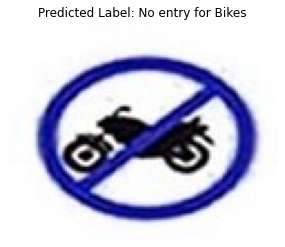

The predicted label for the image is: No entry for Bikes


In [8]:
import matplotlib.pyplot as plt


def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image file '{img_path}' not found.")
    img = cv2.resize(img, (32, 32))  # Resize image to 32x32 pixels
    return img

def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

def predict_image(img_path):
    try:
        img = preprocess_image(img_path)
    except FileNotFoundError as e:
        print(e)
        return None

    img = np.array([img])  
    
    scaler = joblib.load('scaler.pkl')
    pca = joblib.load('pca.pkl')
    svm_model = joblib.load('svm_model.pkl')
    
    hog_features = extract_hog_features(img)
    hog_features = scaler.transform(hog_features)
    hog_features_pca = pca.transform(hog_features)
    
    prediction = svm_model.predict(hog_features_pca)
    
    label_mapping_rev = {v: k for k, v in label_mapping.items()}
    predicted_label = label_mapping_rev.get(prediction[0], "Unknown")
    
    plt.imshow(cv2.imread(img_path), cmap='gray')
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

test_img_path = 'no entry for motor cycle.jpg'
predicted_label_name = predict_image(test_img_path)
print(f'The predicted label for the image is: {predicted_label_name}')
